In [3]:
#import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy import ndimage
import math

C:\Users\aabil\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


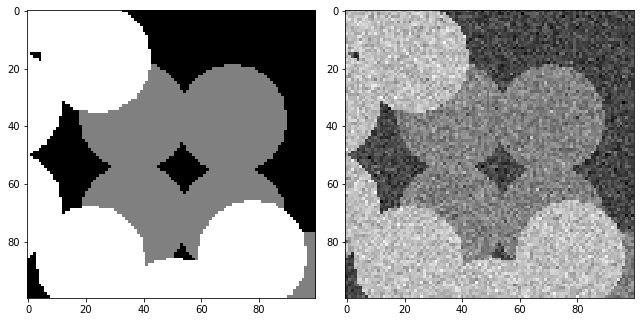

In [16]:
img_true = imageio.imread('data/data/noise_free_circles.png').astype(float)
img_noise = imageio.imread('data/data/noisy_circles.png').astype(float)

fig1, f1_axes = plt.subplots(ncols=2, nrows=1, constrained_layout=False, figsize=(9,6))
f1_axes[0].imshow(img_true, cmap = "gray")
f1_axes[1].imshow(img_noise, cmap = "gray")
fig1.show()
fig1.tight_layout()

In [37]:
print(img_true)

[[190. 190. 190. ...  70.  70.  70.]
 [190. 190. 190. ...  70.  70.  70.]
 [190. 190. 190. ...  70.  70.  70.]
 ...
 [ 70.  70.  70. ... 130. 130. 130.]
 [ 70.  70.  70. ... 130. 130. 130.]
 [ 70.  70.  70. ... 130. 130. 130.]]


Create histogram:

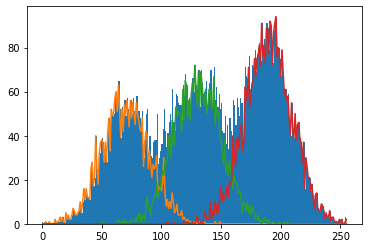

In [62]:
def segmentationHistogram(img_true, img_noise):
    hist_graph = np.zeros((3, 255))
    classes = {70. : 0,
               130. : 1,
               190. : 2}

    for i, row in enumerate(img_true):
        for j, _ in enumerate(row):
            intensity = math.floor(img_noise[i,j])-1
            clss = classes[img_true[i,j]]
            hist_graph[clss, intensity] +=1

    plt.hist(img_noise.flatten(), bins=255)
    plt.plot(np.array(range(255))+1, hist_graph[0,:])
    plt.plot(np.array(range(255))+1, hist_graph[1,:])
    plt.plot(np.array(range(255))+1, hist_graph[2,:])
    plt.show()
    return

segmentationHistogram(img_true, img_noise)

Segmentation energies:

In [87]:
alpha = 0.0005

def V2(f1, f2):
    if f1==f2:
        return 0
    else:
        return 1

def U_l(alpha, img_noise, config): # config contains the intensity values from each class
    return(np.sum(alpha*(config - img_noise)**2))

def U_p(config):
    r, c = config.shape
    s=0
    for i in range(r-2):
        i2=i+1
        for j in range(c-2):
            j2=j+1
            s=s+V2(config[i,j], config[i+1,j])+V2(config[i,j], config[i-1,j])+V2(config[i,j], config[i,j+1])+V2(config[i,j], config[i,j-1])
    return(s)

def segmentationEnergy(alpha, img_noise, config):
    like = U_l(alpha, img_noise, config)
    prior = U_p(config)
    print("Likelihood: ", like)
    print("Prior: ", prior)
    return(like + prior)

segmentationEnergy(alpha, img_noise, img_true)


# Make U_p efficient:

Likelihood:  1999.904
Prior:  1438


3437.904

Configurations

C:\Users\aabil\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


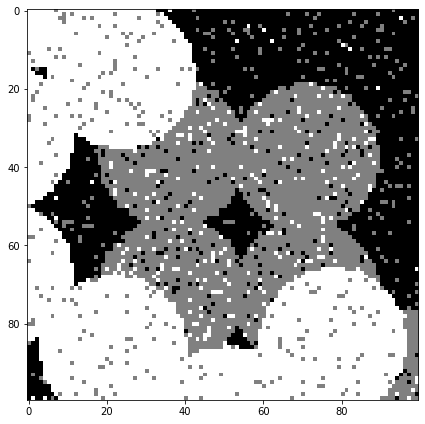

In [83]:
def thresholdConfig(thres1, thres2, img_noise):
    r, c = img_noise.shape
    config = np.zeros((r,c))
    for i in range(r):
        for j in range(c):
            val = img_noise[i,j]
            if val < thres1:
                config[i,j]=70.0
            elif thres1 < val and val < thres2:
                config[i,j]=130.0
            else:
                config[i,j]=190.0
    return config

config1 = thresholdConfig(100, 160, img_noise)

# Plots the thresholded segmentation:
fig1, f1_axes = plt.subplots(ncols=1, nrows=1, constrained_layout=False, figsize=(9,6))
f1_axes.imshow(config1, cmap = "gray")
fig1.show()
fig1.tight_layout()

In [88]:
segmentationEnergy(alpha, img_noise, config1)

Likelihood:  1650.4640000000002
Prior:  7321


8971.464